In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:

import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set()
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import statsmodels.api as sm
#import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
# import the_module_that_warns

warnings.filterwarnings("ignore")

#from fbprophet import Prophet

In [3]:
allProductDf = pd.read_csv('./allProduct.csv')

In [4]:
allProductDf.head()

,Unnamed: 0,price,freight_value,review_score,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_status,order_purchase_timestamp,order_estimated_delivery_date,payment_installments,payment_value,encodedCategory,category_count,Days_to_deliver
0,0,58.9,13.29,5,4.0,650.0,28.0,9.0,14.0,cool_stuff,delivered,2017-09-13 08:59:02,2017-09-29 00:00:00,2,72.19,20,3999,15.625671
1,1,55.9,17.96,5,4.0,650.0,28.0,9.0,14.0,cool_stuff,delivered,2017-06-28 11:52:20,2017-07-26 00:00:00,1,73.86,20,3999,27.505324
2,2,64.9,18.33,4,4.0,650.0,28.0,9.0,14.0,cool_stuff,delivered,2018-05-18 10:25:53,2018-06-07 00:00:00,2,83.23,20,3999,19.565359
3,3,58.9,16.17,5,4.0,650.0,28.0,9.0,14.0,cool_stuff,delivered,2017-08-01 18:38:42,2017-08-25 00:00:00,3,75.07,20,3999,23.223125
4,4,58.9,13.29,5,4.0,650.0,28.0,9.0,14.0,cool_stuff,delivered,2017-08-10 21:48:40,2017-09-01 00:00:00,4,72.19,20,3999,21.091204


In [92]:
testDf=allProductDf.drop(['Unnamed: 0','order_estimated_delivery_date','payment_installments','category_count','order_status'], axis=1)

In [93]:
testDf['Actual Payment value']=testDf['price']+testDf['freight_value']

In [94]:
testDf['order_purchase_timestamp']= pd.to_datetime(testDf['order_purchase_timestamp'])
testDf['Week']=testDf['order_purchase_timestamp'].dt.week

In [95]:
mainDf=testDf[['Week','product_category_name_english','encodedCategory','payment_value','Actual Payment value','review_score','Days_to_deliver']]

In [96]:
mainDf=mainDf.groupby(['Week','product_category_name_english']).agg({'encodedCategory':'first','product_category_name_english':'count','payment_value':'mean', 'Actual Payment value':'mean', 'review_score':'mean','Days_to_deliver':'mean'})

In [97]:
mainDf.columns = ['encodedCategory', 'count_perCategory', 'paymentValue','final_AmountPaid','Review_score','Days_to_deliver']

In [98]:
#mainDf.final_AmountPaid=mainDf.final_AmountPaid-(mainDf.final_AmountPaid/2)

In [99]:
mainDf=mainDf.reset_index(level=['product_category_name_english','Week'])

In [100]:
mainDf["DiscountPercent"]=(mainDf['paymentValue']-mainDf['final_AmountPaid'])/mainDf['paymentValue']

In [101]:
mainDf["DiscountPercent"]=mainDf.DiscountPercent.apply(lambda x: 0 if x <=0 else x*100)

In [102]:
sumList=[]
for ind in mainDf.index: 
    #print(mainDf['encodedCategory'][ind], mainDf['Week'][ind]) 
    week=mainDf['Week'][ind]
    category=mainDf['encodedCategory'][ind]
    listWeek=list(range(week-6, week))
    #print(listWeek)
    salesSum=mainDf.loc[(mainDf['encodedCategory'] == category) & mainDf['Week'].isin(listWeek),'count_perCategory'].sum()
    salesAvg=salesSum/6
    #print(salesAvg)
    sumList.append(salesAvg) 
    
    
    

In [103]:
mainDf["SaleRecord_last6week"]=sumList

In [104]:
mainDf.head(100)

,Week,product_category_name_english,encodedCategory,count_perCategory,paymentValue,final_AmountPaid,Review_score,Days_to_deliver,DiscountPercent,SaleRecord_last6week
0,1,agro_industry_and_commerce,0,4,624.422500,624.422500,3.250000,30.078073,0.000000,0.000000
1,1,air_conditioning,1,2,240.350000,240.350000,3.000000,27.333142,0.000000,0.000000
2,1,art,2,3,149.023333,149.023333,4.000000,26.532207,0.000000,0.000000
3,1,audio,4,2,432.745000,432.745000,3.000000,30.318096,0.000000,0.000000
4,1,auto,5,57,179.637193,155.896316,4.315789,27.071564,13.216014,0.000000
...,...,...,...,...,...,...,...,...,...,...
95,2,home_confort,47,6,118.450000,139.313333,3.500000,24.236792,0.000000,0.833333
96,2,home_construction,48,13,485.085385,249.609231,3.692308,29.410897,48.543238,0.666667
97,2,housewares,49,91,159.828571,163.546374,3.857143,27.817176,0.000000,10.833333
98,2,industry_commerce_and_business,50,6,242.041667,122.021667,3.000000,23.327348,49.586504,1.000000


In [105]:
X=mainDf.drop(['product_category_name_english','count_perCategory'], axis=1)


In [106]:
Y=mainDf['count_perCategory']

In [107]:
week=np.arange(1, 35, 1).tolist()

In [108]:
trainDf= mainDf[mainDf.Week.isin(week)]

In [109]:
testDF=mainDf[~mainDf.Week.isin(week)]

In [110]:
X_train1=trainDf.drop(['product_category_name_english','count_perCategory'], axis=1)

In [111]:
Y_train1=trainDf['count_perCategory']

In [112]:
X_test1=testDF.drop(['product_category_name_english','count_perCategory'], axis=1)

In [113]:
Y_test1=testDF['count_perCategory']

In [27]:
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df.count_perCategory, [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.count_perCategory.max())
    print('Min sale:', sales_df.count_perCategory.min())
    print('Avg sale:', sales_df.count_perCategory.mean())
    print()
    return sales_df

sales_df = sales_dist(trainDf)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 389
Min sale: 1
Avg sale: 43.26004842615012

Sales bucket v/s Total percentage:


(0, 50]       74.900990
(50, 100]     13.118812
(100, 150]     4.752475
(200, 250]     3.811881
(150, 200]     3.415842
Name: sales_bins, dtype: float64

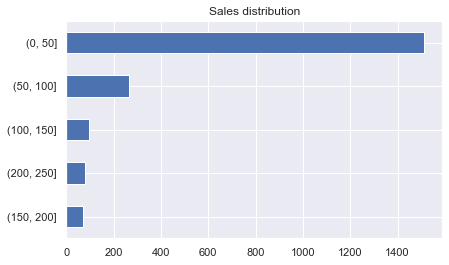

In [29]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
# sns.countplot(sales_count)

In [30]:
def discountPercent(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['discount_bins'] = pd.cut(sales_df.count_perCategory, [0,10,20,30,40,50,60,70,80,90,100])
    print('Max discount:', sales_df.DiscountPercent.max())
    print('Min discount:', sales_df.DiscountPercent.min())
    print('Avg discount:', sales_df.DiscountPercent.mean())
    print()
    return sales_df

discount_df = discountPercent(trainDf)

# Total number of data points
total_points = pd.value_counts(discount_df.discount_bins).sum()
print('Discount percentage distribution')
display(pd.value_counts(discount_df.discount_bins).apply(lambda s: (s/total_points)*100))

Max discount: 88.1530169631189
Min discount: 0.0
Avg discount: 12.121013002824709

Discount percentage distribution


(0, 10]      58.380202
(10, 20]     14.285714
(20, 30]      6.074241
(30, 40]      3.543307
(60, 70]      3.318335
(50, 60]      3.262092
(80, 90]      3.149606
(90, 100]     2.924634
(40, 50]      2.812148
(70, 80]      2.249719
Name: discount_bins, dtype: float64

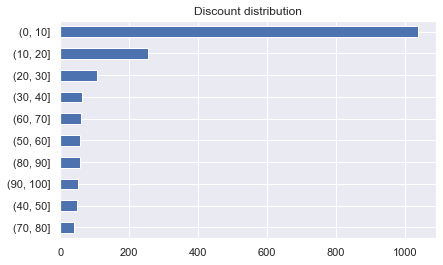

In [31]:
# Let us visualize the same
discount = pd.value_counts(discount_df.discount_bins)
discount.sort_values(ascending=True).plot(kind='barh', title='Discount distribution', );
# sns.countplot(sales_count)

In [32]:
avgSalesPerProduct=mainDf[['encodedCategory','count_perCategory']]
avgSalesPerProduct=avgSalesPerProduct.groupby(['encodedCategory']).agg({'encodedCategory':'first','count_perCategory':'mean'})

In [33]:
avgSalesPerProduct.head()

,encodedCategory,count_perCategory
encodedCategory,,
0,0,5.142857
1,1,6.425532
2,2,4.977273
3,3,2.666667
4,4,7.326923


In [48]:

avg_sales_per_item_across_stores_sorted = avgSalesPerProduct.count_perCategory.values
# Scatter plot of average sales per item
sales_item_data = go.Bar(
    x=[i for i in range(0, 50)],
    y=avg_sales_per_item_across_stores_sorted,
    marker=dict(
        color=avg_sales_per_item_across_stores_sorted,
        colorscale='Blackbody',
        showscale=True
    ),
    #text = avg_sales_per_item_across_stores_df.item.values
)
data = [sales_item_data]

sales_item_layout = go.Layout(
    autosize= True,
    title= 'Scatter plot of avg sales per item',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Items',
        ticklen= 1,
        zeroline= False,
        gridwidth= 1,
    ),
    yaxis=dict(
        title= 'Avg Sales',
        ticklen= 1,
        zeroline= False,
        gridwidth= 1,
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=sales_item_layout)
py.iplot(fig,filename='scatter_sales_item')

The distribution of sales is not uniform across the items available  

Time series distribution of sales 

In [35]:
timeDf=mainDf[['Week','count_perCategory']]
timeDf=timeDf.groupby(['Week']).agg({'count_perCategory':'sum'})
timeDf.columns = ['sales_per_week']
timeDf=timeDf.reset_index(level=['Week'])

In [36]:
timeDf.head()

,Week,sales_per_week
0,1,1652
1,2,2147
2,3,2218
3,4,2310
4,5,2410


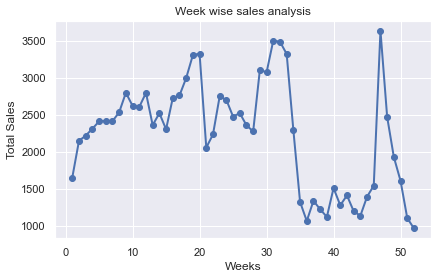

In [37]:
plt.plot(timeDf.Week, timeDf.sales_per_week,
         linewidth=2.0,
         linestyle='-',
         color='b',
         alpha=1.0,marker='o')
plt.xlabel('Weeks')
plt.ylabel('Total Sales')
plt.title('Week wise sales analysis')
plt.show()

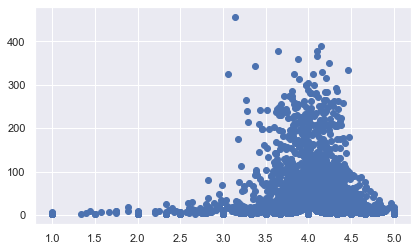

In [38]:
plt.scatter(mainDf.Review_score,mainDf.count_perCategory)

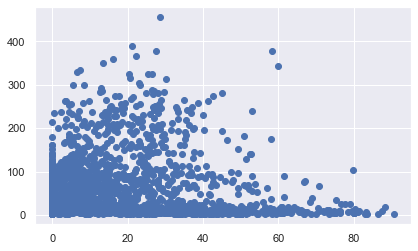

In [86]:
plt.scatter(mainDf.DiscountPercent,mainDf.count_perCategory)

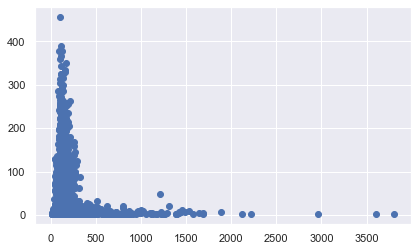

In [87]:
plt.scatter(mainDf.final_AmountPaid,mainDf.count_perCategory)

In [39]:
from pandas_profiling import ProfileReport

In [40]:
profile=ProfileReport(mainDf,title='Dataset Profiling Report',explorative=True)

In [41]:
profile.to_widgets()

In [42]:
profile.to_file('EDA_report.html')

In [43]:
import xgboost
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
def train(model, X, y):
    # train the model
    model.fit(X, y)
    
    # predict the training set
    pred = model.predict(X)
    
    # perform cross-validation
    cv_score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
    cv_score = np.abs(np.mean(cv_score))
    
    print("Model Report")
    print("MSE:",mean_squared_error(y,pred,sample_weight=y))
    print("CV Score:", cv_score)

In [50]:

modelXG = xgboost.XGBRegressor() 
train(modelXG,X_train1,Y_train1)
modelLR = LinearRegression(normalize=True)
train(modelLR,X_train1,Y_train1)
modelRidge = Ridge()
train(modelRidge,X_train1,Y_train1)
modelRF=RandomForestRegressor()
train(modelRF,X_train1,Y_train1)
#coef = pd.Series(model.coef_, X.columns).sort_values()
#coef.plot(kind='bar', title="Model Coefficients")
#model.fit(X_train1,Y_train1)

Model Report
MSE: 5.223019338065207
CV Score: 735.8056273713598
Model Report
MSE: 2298.1328570044925
CV Score: 724.1123581435675
Model Report
MSE: 2298.1336857372694
CV Score: 724.1096464181794
Model Report
MSE: 188.15914742309585
CV Score: 664.3770081840194


In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
xgb1 = xgboost.XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [0.02], #so called `eta` value
              'max_depth': [9,10,11,20],
              'min_child_weight': [3],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,550,600]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)


In [53]:
xgb_grid.fit(X_train1, Y_train1)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   37.8s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   50.5s finished


[00:11:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:11:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
0.8772219750822392
{'colsample_bytree': 0.7, 'learning_rate': 0.02, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [114]:
model=xgboost.XGBRegressor(nthread=4,learning_rate=0.02,max_depth=9,min_child_weight=3,n_estimators=500)
model.fit(X_train1, Y_train1)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=9,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [115]:
#y_pred_xg = model.predict(xgb.DMatrix(X_test1), ntree_limit = model.best_ntree_limit)
y_pred_xg=model.predict(X_test1)
df_xg=pd.DataFrame(X_test1)

In [116]:
df_xg['predicted']=y_pred_xg

In [117]:
df_xg['predicted']=df_xg.predicted.apply(lambda x: 0 if x <=0 else x)
df_xg['Actual']=Y_test1

In [118]:
df_xg.head()

,Week,encodedCategory,paymentValue,final_AmountPaid,Review_score,Days_to_deliver,DiscountPercent,SaleRecord_last6week,predicted,Actual
2065,35,0,224.600000,56.150000,5.000000,36.021817,75.000000,7.500000,3.454233,4
2066,35,1,561.277500,319.352500,4.750000,14.672807,43.102565,8.000000,5.474029,4
2067,35,2,83.465000,83.465000,4.500000,12.122361,0.000000,4.666667,3.894672,2
2068,35,4,22.290000,22.290000,5.000000,5.612465,0.000000,9.833333,4.962832,1
2069,35,5,113.403793,113.403793,4.517241,16.957255,0.000000,139.166667,136.144409,29


In [119]:
(df_xg['predicted'] - df_xg['Actual']).abs().idxmax()


2691

In [120]:
df_xg.loc[ 2691 , : ]

Week                     47.000000
encodedCategory           7.000000
paymentValue            149.142079
final_AmountPaid        106.351882
Review_score              3.144420
Days_to_deliver          22.250766
DiscountPercent          28.690895
SaleRecord_last6week    151.166667
predicted               166.511368
Actual                  457.000000
Name: 2691, dtype: float64

In [121]:
mean_absolute_error(Y_test1,y_pred_xg,sample_weight=Y_test1)

45.79805592110194

In [122]:
timeDfPred=df_xg[['Week','predicted','Actual']]
timeDfPred=timeDfPred.groupby(['Week']).agg({'predicted':'sum','Actual':'sum'})
timeDfPred.columns = ['sales_per_week_pred','sales_per_week_actual']
timeDfPred=timeDfPred.reset_index(level=['Week'])

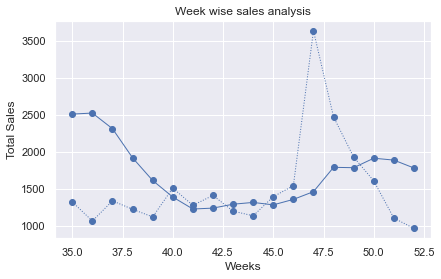

In [123]:
plt.plot(timeDfPred.Week, timeDfPred.sales_per_week_pred,
         linewidth=1.0,
         linestyle='-',
         color='b',
         alpha=1.0,marker='o')
plt.plot(timeDfPred.Week, timeDfPred.sales_per_week_actual,
         linewidth=1.0,
         linestyle='dotted',
         color='b',
         alpha=1.0,marker='o')

plt.xlabel('Weeks')
plt.ylabel('Total Sales')
plt.title('Week wise sales analysis')
plt.show()